<a href="https://colab.research.google.com/github/ferdouszislam/Bangla-Handwritting-Aesthetics-Prediction-ML/blob/main/codes/experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

In [2]:
# mount gdrive with this code
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# extract the zip file containing our dataset
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/BanglaLekha-Isolated_aesthetics_dataset/prepared-datasets.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
# set all random seeds
SEED = 42

def set_global_seed(val):
  #torch.backends.cudnn.deterministic = True
  #torch.backends.cudnn.benchmark = False
  #random.seed(val)
  torch.manual_seed(val)
  torch.cuda.manual_seed(val)
  torch.cuda.manual_seed_all(val)
  #np.random.seed(val)

set_global_seed(SEED)

In [6]:
# custom dataset class
class BanglaAestheticsDataset(Dataset):
  def __init__(self, labels_csv_file, img_dir, transform=None):
    self.labels_df = pd.read_csv(labels_csv_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels_df)

  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir, self.labels_df.iloc[index, 0])
    image = io.imread(img_path)
    if self.transform:
      image = self.transform(image)
    y_label = torch.tensor(int(self.labels_df.iloc[index, 3]))
    
    return (image, y_label)

In [7]:
# load data

# resize to same shape and convert to tensor
custom_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((50, 50)), transforms.ToTensor()])

train_dataset = BanglaAestheticsDataset(labels_csv_file='/tmp/prepared-datasets/aesthetics_train.csv', 
                                        img_dir='/tmp/prepared-datasets/train_images', transform=custom_transform)

val_dataset = BanglaAestheticsDataset(labels_csv_file='/tmp/prepared-datasets/aesthetics_val.csv', 
                                        img_dir='/tmp/prepared-datasets/validation_images', transform=custom_transform)

test_dataset = BanglaAestheticsDataset(labels_csv_file='/tmp/prepared-datasets/aesthetics_test.csv', 
                                        img_dir='/tmp/prepared-datasets/test_images', transform=custom_transform)

In [8]:
# data loaders

batch_size = 10 # no of samples in a single batch

set_global_seed(SEED)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

set_global_seed(SEED)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

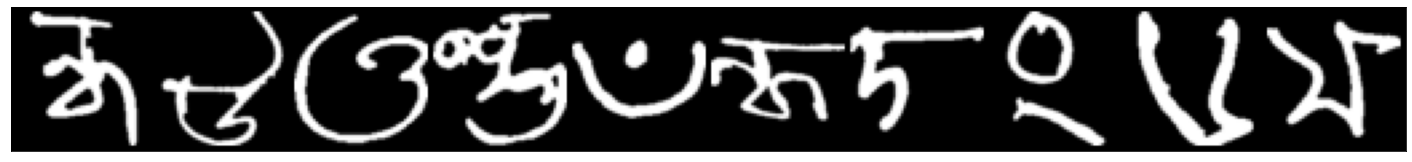

In [9]:
# visualize data
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (25,4))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=25).permute(1,2,0))
        break
        
show_batch(val_loader)

# ANN experimentation starts from here

In [10]:
# hyperparameters
INPUT_SIZE = 50*50
ANN_FC1_SIZE = 256
ANN_FC2_SIZE = 128
ANN_FC3_SIZE = 32
CONV1_FILTERS = 16
CONV2_FILTERS = 32
NUM_EPOCHS = 2
LEARNING_RATE = 0.0015

In [11]:
# custom ANN class with 3 hidden layers, relu activation and dropout of 0.5 on each hidden layer
class ANN(nn.Module):
  def __init__(self, input_size=INPUT_SIZE, fc1_size=256, fc2_size=128, fc3_size=32):
    super(ANN, self).__init__()
    self.input_size = input_size
    self.fc1 = nn.Linear(input_size, fc1_size)
    self.dropout_fc1 = nn.Dropout(0.5)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.dropout_fc2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(fc2_size, fc3_size)
    self.dropout_fc3 = nn.Dropout(0.5)
    self.output_layer = nn.Linear(fc3_size, 1)

  def forward(self, input):
    # flatten input
    input = input.reshape(-1, self.input_size) 
    # input layer to hidden layer 1
    output = self.dropout_fc1(self.fc1(input))
    output = self.relu(output)
    # hidden layer 1 to hidden layer 2
    output = self.dropout_fc2(self.fc2(output))
    output = self.relu(output)
    # hidden layer 2 to hidden layer 3
    output = self.dropout_fc3(self.fc3(output))
    output = self.relu(output)
    # hidden layer 3 to output
    output = self.output_layer(output)
    pred = torch.sigmoid(output) # probability prediction
    return pred

In [12]:
# custom cnn class 
class CNN(nn.Module):
  def __init__(self, conv1_filters=16, conv2_filters=32, fc1_size=256, fc2_size=64):
    super(CNN, self).__init__()
    
    self.conv1_filters = conv1_filters
    self.conv2_filters = conv2_filters

    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(1, conv1_filters, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(conv1_filters),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_layer2 =  nn.Sequential(
        nn.Conv2d(conv1_filters, conv2_filters, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(conv2_filters),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # conv layer explanation with: conv1_filters=16, conv2_filters=32
    # 1x50x50 --conv1--> 16x50x50 --maxpool--> 16x25x25
    # 16x25x25 --conv2--> 32x25x25 --maxpool--> 32x12x12

    self.fc1 = nn.Linear(conv2_filters*12*12, fc1_size) 
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.relu = nn.ReLU()
    self.fc_dropout = nn.Dropout(0.5)
    self.output_layer = nn.Linear(fc2_size, 1)
      
  def forward(self, input):
    #print('inside forward', input.shape)

    # input to conv_layer1
    output = self.conv_layer1(input)
    #print('after conv1', output.shape)

    # conv_layer1 to conv_layer2
    output = self.conv_layer2(output)
    #print('after conv2', output.shape)

    # conv_layer2 to fc1
    output = output.reshape(-1, self.conv2_filters*12*12) # flatten
    output = self.fc1(output)
    output = self.relu(self.fc_dropout(output))

    # fc1 to fc2
    output = self.fc2(output)
    output = self.relu(self.fc_dropout(output))

    # fc2 to prediction
    output = self.output_layer(output)
    pred = torch.sigmoid(output)

    return pred

  def _get_result_dims(input_dims, conv_dims, p=0, s=1):
    # get resulting matrix(2d) dimensions after convolution
    
    resulting_dims = []
    resulting_dims.append(int((input_dims[0] - conv_dims[0] + 2*p)/s)+1)
    resulting_dims.append(int((input_dims[1] - conv_dims[1] + 2*p)/s)+1)
    
    return resulting_dims

In [13]:
# class to calculate accuracy of model, using batches of data
class Accuracy_Calc():
  def __init__(self):
    self.n_correct_samples = 0
    self.n_total_samples = 0

  def add_batch(self, pred_labels, gt_labels):
    pred_labels = torch.round(pred_labels)
    gt_labels = torch.round(gt_labels)

    self.n_total_samples+=gt_labels.size(0)
    self.n_correct_samples+=pred_labels.eq(gt_labels).sum().item()

  def get_accuracy(self):
    return 100*self.n_correct_samples/self.n_total_samples

In [14]:
PATH_TO_ANN_MODEL = 'ann_model.pth'
PATH_TO_CNN_MODEL = 'cnn_model.pth'

# training loop
def train(model, optimizer, criterion, train_loader, num_epochs, SAVE_PATH):
  min_valid_loss = np.inf
  total_train_step = len(train_loader)

  train_accuracies = []
  val_accuracies = []
  selected_epoch = -1
  
  # train loop
  for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc_calc = Accuracy_Calc()
    
    model.train() # set the model in train mode
    for step, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      labels = labels.unsqueeze(1)
      labels = labels.float()

      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # accumulate training loss
      train_loss+=loss.item()
      with torch.no_grad():
        # accumulate train accuracy
        train_acc_calc.add_batch(outputs, labels)

    valid_loss = 0.0
    val_acc_calc = Accuracy_Calc()

    model.eval() # set the model to evaluation mode
    with torch.no_grad():
      for step, (images, labels) in enumerate(val_loader):
        # if flatten_input:
        #   images = images.reshape(-1, 50*50) # flatten image
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        labels = labels.unsqueeze(1)
        labels = labels.float()

        loss = criterion(outputs, labels)

        # accumulate validation loss
        valid_loss+=loss.item()
        # accumulate validation accuracy
        val_acc_calc.add_batch(outputs, labels)

    train_loss /= len(train_loader)
    valid_loss /= len(val_loader)
    train_accuracies.append(train_acc_calc.get_accuracy())
    val_accuracies.append(val_acc_calc.get_accuracy())
    
    print(f'epoch {epoch+1} --- training- loss: {train_loss:.3f}, acc: {train_acc_calc.get_accuracy():.3f} \
    --- validation- loss: {valid_loss:.3f}, acc: {val_acc_calc.get_accuracy():.3f}')

    if min_valid_loss > valid_loss:
        print(f'validation loss decreased({min_valid_loss:.4f}--->{valid_loss:.4f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        #torch.save(model, 'saved_model.pth')
        model.to(device)
        torch.save(model.state_dict(), SAVE_PATH)
        selected_epoch = epoch

  return selected_epoch, train_accuracies, val_accuracies

# evaluation 
def eval(model, test_loader):
  model.eval()
  with torch.no_grad():
    n_correct_samples = 0
    n_total_samples = 0
    for imgs, labels in test_loader:
      imgs = imgs.to(device)
      labels = labels.to(device).reshape(-1, 1)

      outputs = model(imgs)

      #pred = outputs.round() # if outputs>=0.5 class = 1, else class = 0
      pred = torch.round(outputs)

      #print(pred.shape, labels.shape)
      
      n_total_samples+=labels.size(0)
      n_correct_samples+=pred.eq(labels).sum().item()

    print(f'Accuracy = {100*n_correct_samples/n_total_samples : 0.3f}')

# plot lists of train, validation accuracy
def plot_accuracies(train_accs, val_accs, num_epochs=NUM_EPOCHS, selected_epoch=None, title="train and validation accuracies "):
  plt.figure(figsize =(15,9))
  plt.title(title, fontdict = {'fontsize' : 18})
  epochs = [epoch for epoch in range(num_epochs)]
  plt.plot(epochs, train_accs, 'ro-',  epochs, val_accs ,'bv-')

  if selected_epoch:
    plt.axvline(x=selected_epoch, color='k', linestyle='--')
    plt.legend(['train accuracies','validation accuracies', 'selected epoch'], fontsize=16)
  
  plt.xlabel('Epochs', fontsize=18)
  plt.ylabel('Accuracy', fontsize=18)
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.show()

In [ ]:
# init model with ANN
set_global_seed(SEED)
model = ANN(input_size=INPUT_SIZE, fc1_size=ANN_FC1_SIZE, fc2_size=ANN_FC2_SIZE, fc3_size=ANN_FC3_SIZE)
model = model.to(device)

# init loss function, optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

selected_epoch, train_accs, val_accs = train(model, optimizer, criterion, train_loader, NUM_EPOCHS, SAVE_PATH=PATH_TO_ANN_MODEL)

epoch 1 --- training- loss: 0.681, acc: 57.162     --- validation- loss: 0.681, acc: 54.580
validation loss decreased(inf--->0.6806) 	 Saving The Model


In [ ]:
plot_accuracies(train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
model = ANN(input_size=INPUT_SIZE, fc1_size=ANN_FC1_SIZE, fc2_size=ANN_FC2_SIZE, fc3_size=ANN_FC3_SIZE)
model.load_state_dict(torch.load(PATH_TO_ANN_MODEL))
model = model.to(device)
eval(model=model, test_loader=test_loader)

In [ ]:
# init model with CNN
set_global_seed(SEED)
model = CNN()
model = model.to(device)

# init loss function, optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

selected_epoch, train_accs, val_accs = train(model, optimizer, criterion, train_loader, NUM_EPOCHS, SAVE_PATH=PATH_TO_CNN_MODEL)

In [ ]:
plot_accuracies(train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
model = CNN()
model.load_state_dict(torch.load(PATH_TO_CNN_MODEL))
model = model.to(device)
eval(model=model, test_loader=test_loader)